In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

import ttach as tta
from typing import Callable, List, Tuple, Optional
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index): 
        path, _ = self.samples[index] 
        sample, target = super(MyImageFolder, self).__getitem__(index) 
        return sample, target, path[-16:-4]

In [3]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_transform_gpu = transforms.Compose([
    transforms.RandomCrop(224,32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform_gpu = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('./task_images_downsampled/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('./task_images_downsampled/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers = get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers = get_dataloader_workers())

In [4]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

def displayImg_grayscale(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(npImg)
    plt.show()

00001862_005
tensor(0)


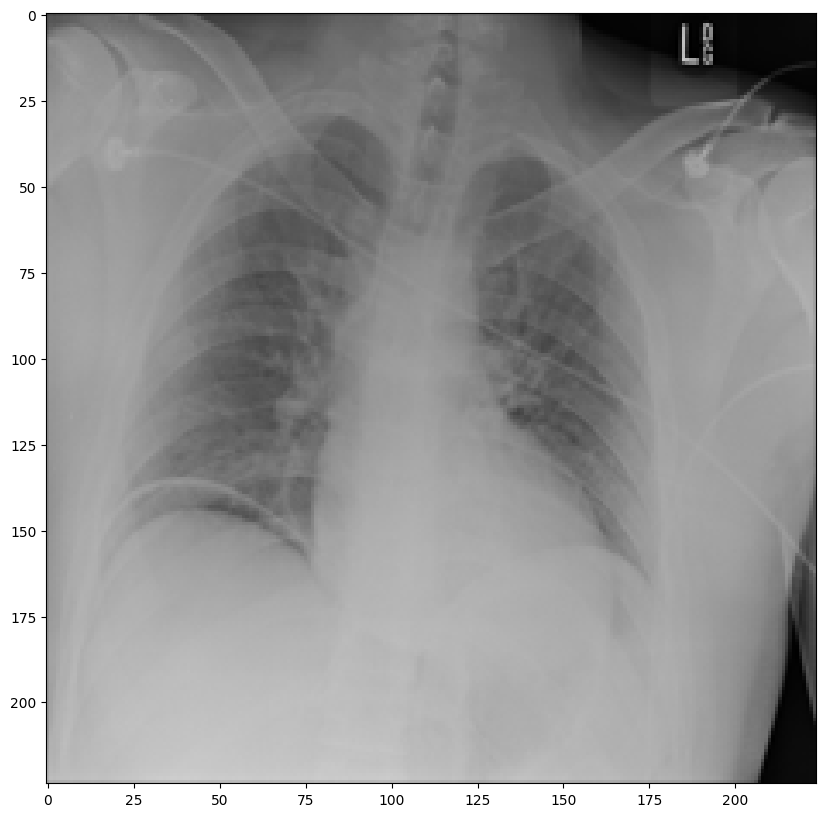

00000357_000
tensor(0)


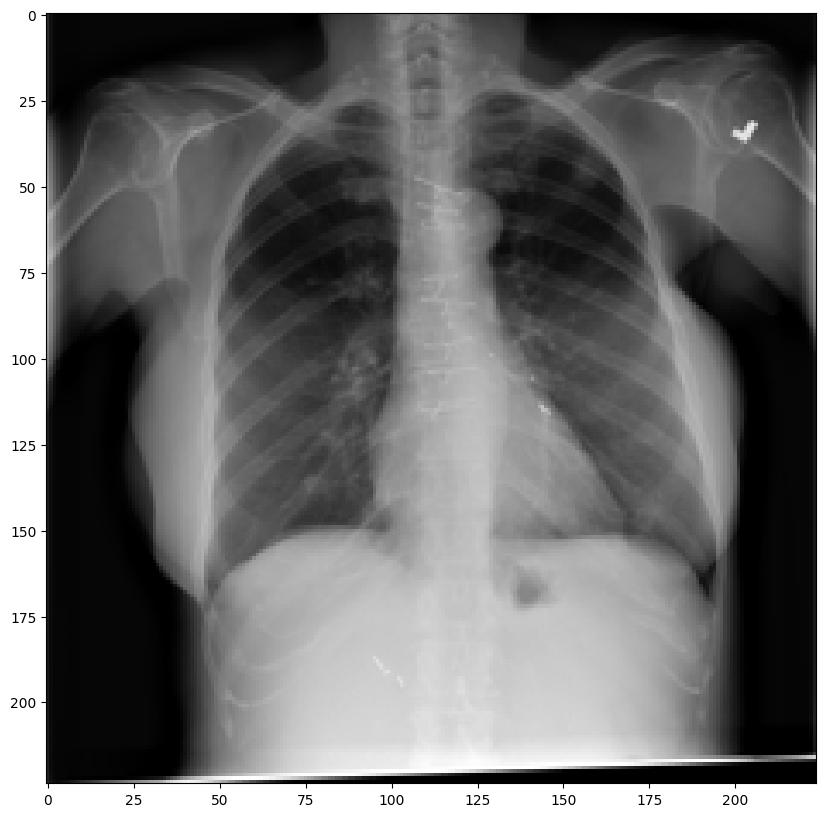

00020384_000
tensor(0)


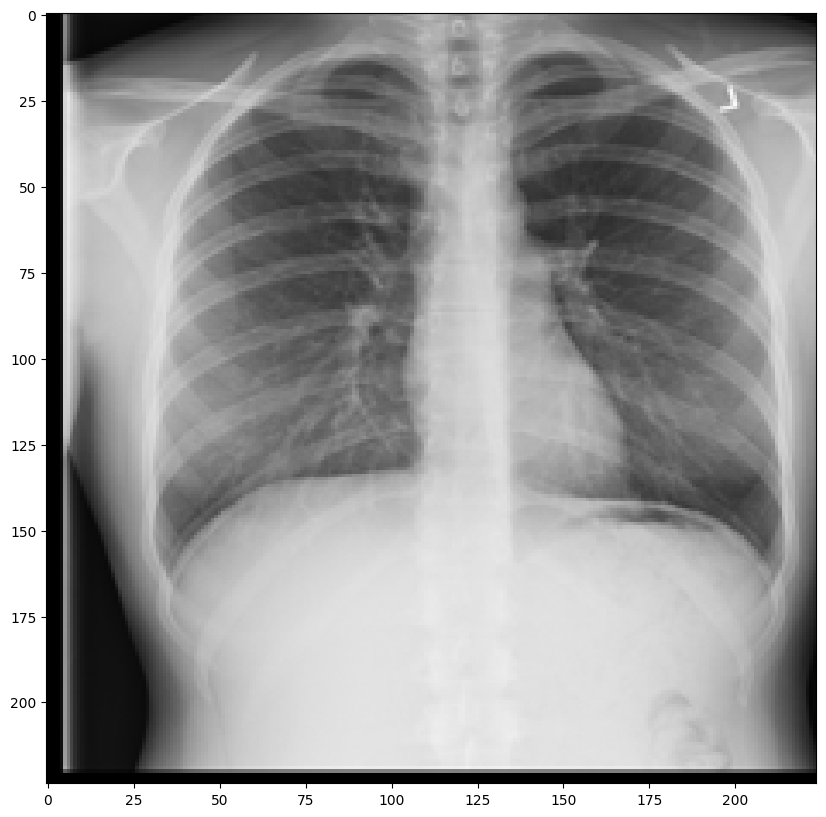

In [5]:
someImages = None
someLabels = None
somePaths = None
i=0
for X,y,path in iter(train_dl):
    someImages=X
    someLabels=y
    somePaths = path
    break

for i in range(0,3):
    print(somePaths[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DynamicDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout_mask):
        return input * dropout_mask

class ResNet(nn.Module):
    def __init__(self,task_one_dimension=2):
        super().__init__()
        resnet = resnet18(num_classes=2)
        resnet.load_state_dict(torch.load('best.pkl'))
        
        modules = list(resnet.children())[:-2]
        self.feature_extractor = nn.Sequential(*modules)
        self.dynamic_dropout = DynamicDropout()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = resnet.fc

    def forward(self,x,dropout_mask):
        features = self.feature_extractor(x)
        features = self.dynamic_dropout(features, dropout_mask)
        features = self.pool(features)
        features = features.view(features.size(0), -1)
        output = self.linear(features)
        return output

model = ResNet(task_one_dimension=2).to(device)
print(model.feature_extractor)

Using cuda device
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.001,last_epoch=-1)

00009331_000
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')
tensor(-1., device='cuda:0')


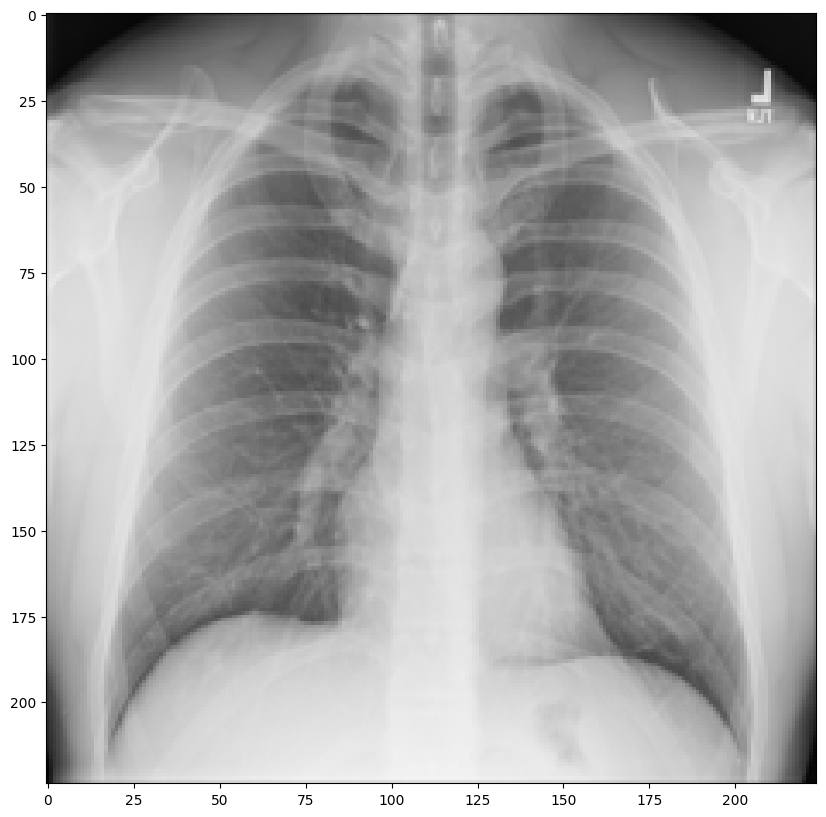

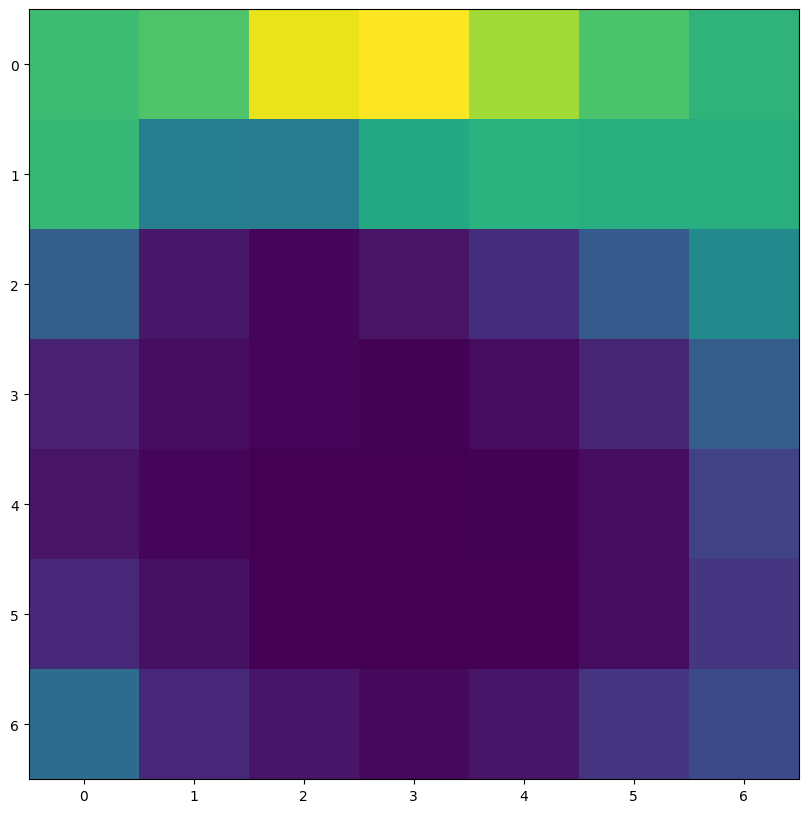

00010912_000
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')
tensor(-1., device='cuda:0')


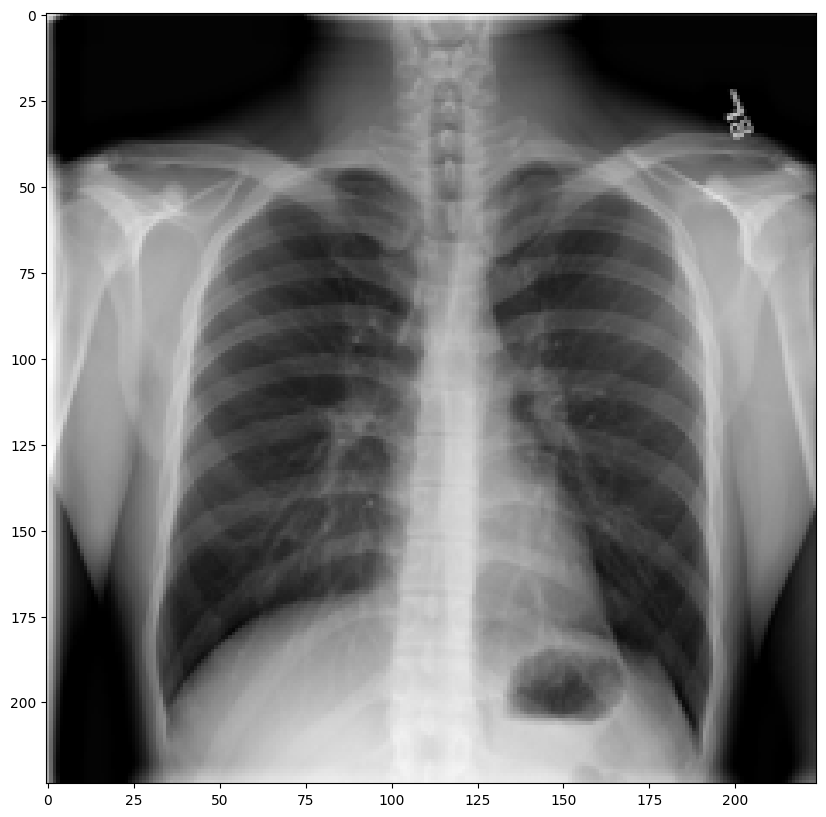

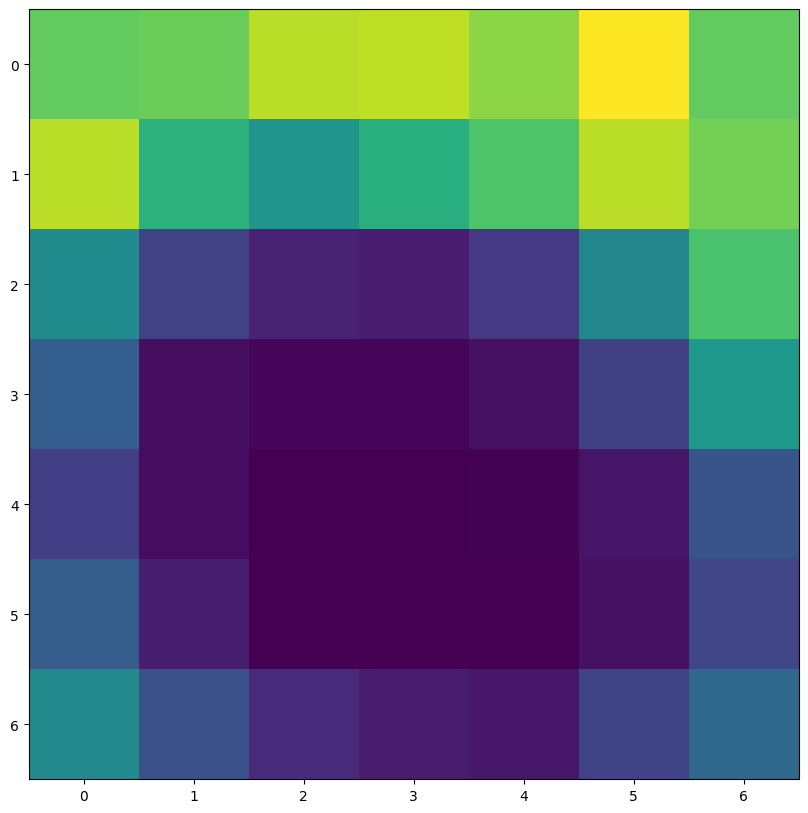

00001104_001
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')
tensor(-1., device='cuda:0')


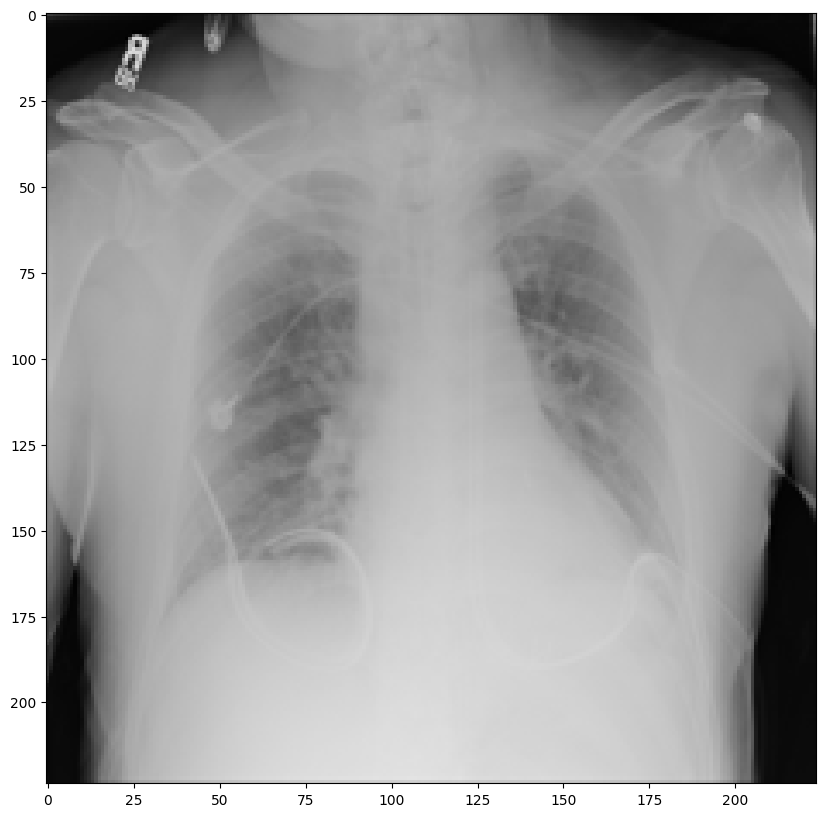

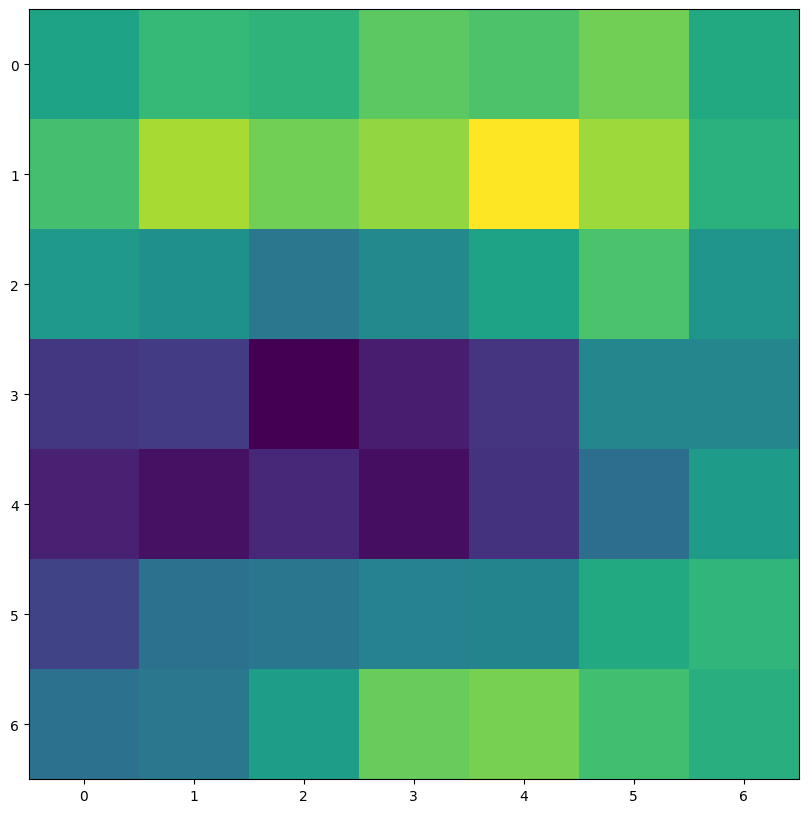

In [8]:
for X,y,path in iter(train_dl):
    X,y = X.to(device),y.to(device)
    normal_X = normal_transform(X).to(device)
    for i in range(3):
        print(path[i])
        print(y[i])
        print(model(normal_X[i:i+1],torch.ones((512,7,7)).to(device)).argmax(1))
        grayscale_cam = torch.tensor(np.load('./dropout_prob/'+path[i]+'.npz')['compressed_array']).to(device)
        print(grayscale_cam.min())
        grayscale_cam[grayscale_cam>=-0.1] = 1
        grayscale_cam[grayscale_cam<-0.1] = 0
        displayImg(X[i].cpu())
        #displayImg_grayscale(grayscale_cam[1].cpu())
        displayImg_grayscale(torch.mean(grayscale_cam,axis=0).cpu())
    break

In [9]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)

    def __getitem__(self, index): 
        path, _ = self.samples[index]
        heatmap = torch.tensor(np.load('./dropout_prob/'+path[-16:-4]+'.npz')['compressed_array'])
        sample, target = super(TrainImageFolder, self).__getitem__(index) 
        return sample, target, heatmap

train_ds = TrainImageFolder('task_images_downsampled/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers= get_dataloader_workers())

tensor(0)


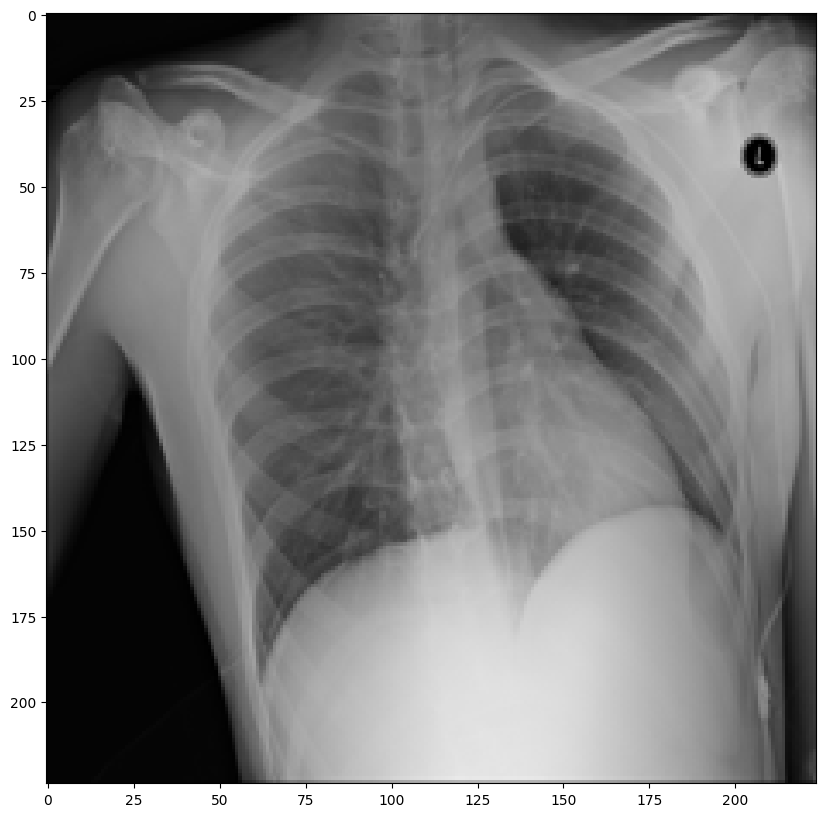

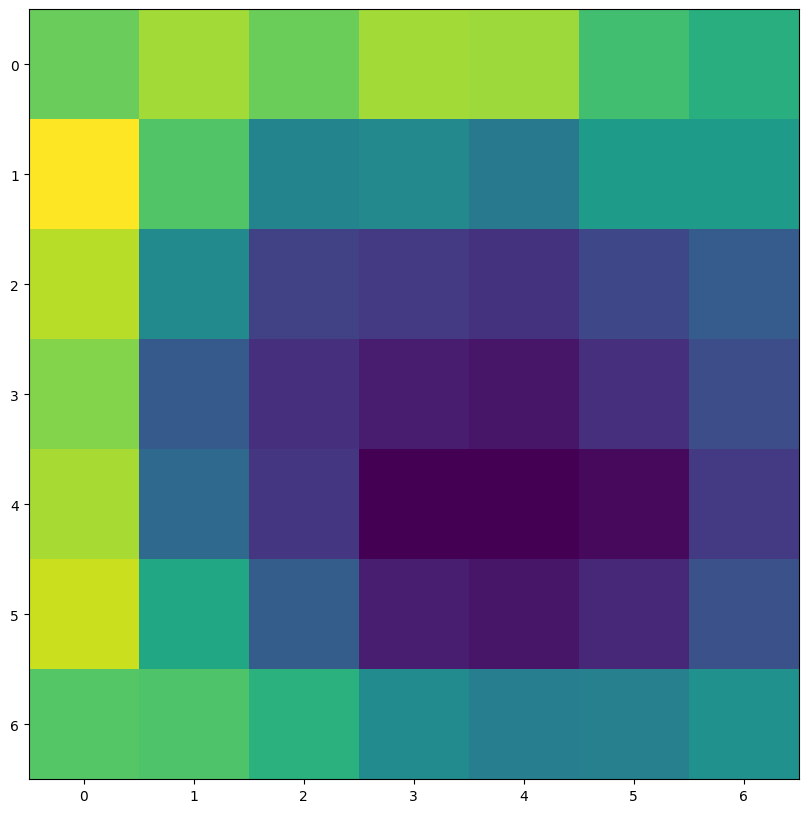

tensor(0)


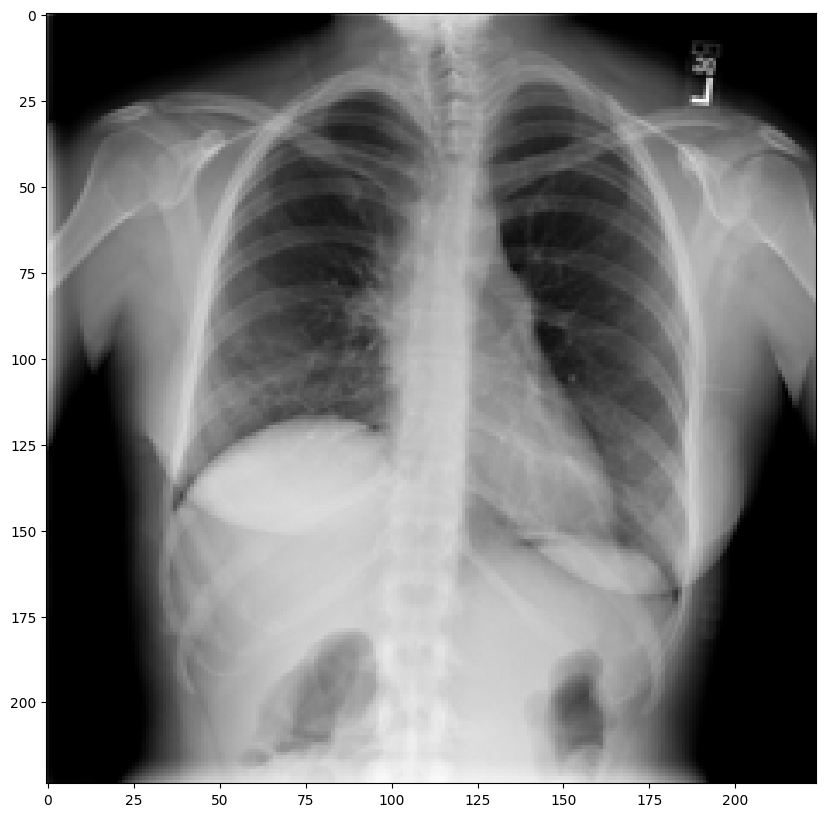

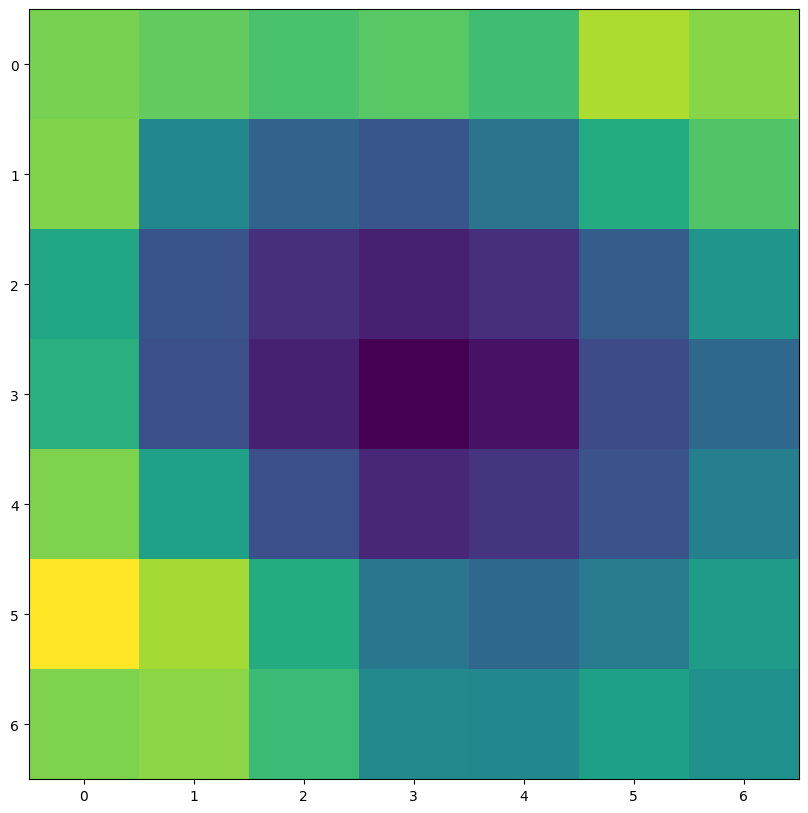

tensor(0)


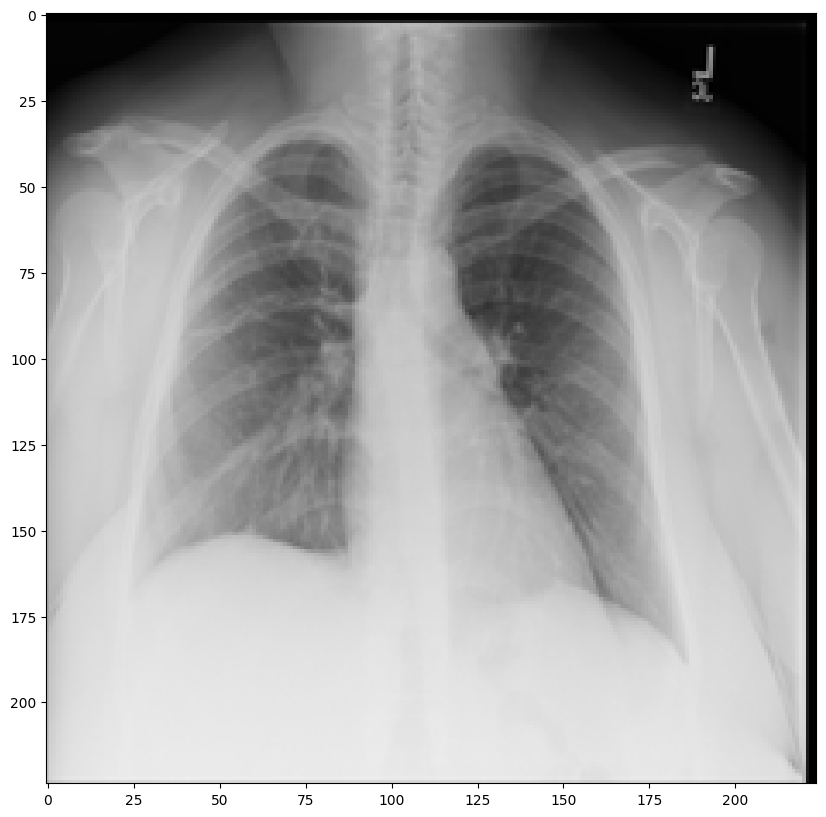

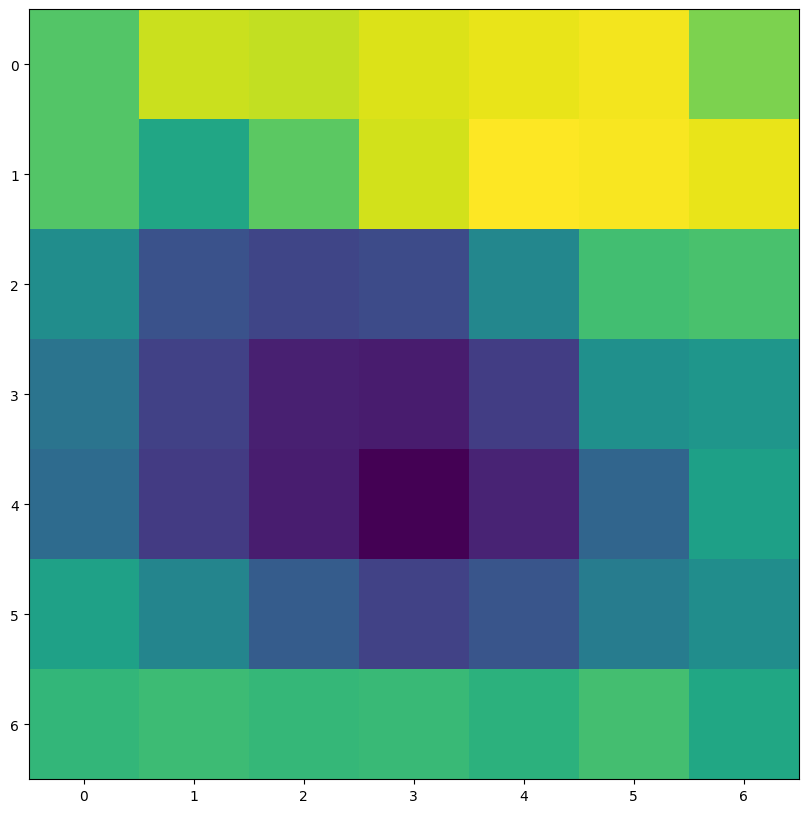

In [10]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(3):
    print(someLabels[i])
    displayImg(someImages[i])
    displayImg_grayscale(someMasks[i].mean(0))

In [11]:
def train_dropout(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,dropout in tqdm(dataloader):
        X,y,dropout = X.to(device), y.to(device), dropout.to(device)
        X = train_transform_gpu(X)
        dropout[dropout>=-0.1] = 1
        dropout[dropout<-0.1] = 0
        # compute prediction
        predict = model(X,dropout)
        # compute loss
        loss = loss_fn(predict,y)
        # backpropagation
        loss.backward()
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
        optimizer.step()
        optimizer.zero_grad()
    return train_loss,train_accuracy/size

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,index in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        X = train_transform_gpu(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,torch.ones((len(X),512,7,7)).to(device))
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            X = test_transform_gpu(X)
            predict = model(X,torch.ones((len(X),512,7,7)).to(device))
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [12]:
epochs = 75
#model.load_state_dict(torch.load('checkpoint.pkl'))
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train_dropout(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

Epoch, 0


100%|██████████| 188/188 [00:09<00:00, 19.63it/s]


train_loss: 262.84731962531805   train_accuracy: 87.84655792989396
test_loss: 103.26839745044708   test_accuracy: 78.96666666666667
Epoch, 1


100%|██████████| 188/188 [00:09<00:00, 19.63it/s]


train_loss: 248.73550757020712   train_accuracy: 88.77233373325983
test_loss: 256.94435849785805   test_accuracy: 17.875
Epoch, 2


100%|██████████| 188/188 [00:09<00:00, 19.01it/s]


train_loss: 246.2773183733225   train_accuracy: 88.94095139271701
test_loss: 281.25745506584644   test_accuracy: 16.691666666666666
Epoch, 3


100%|██████████| 188/188 [00:09<00:00, 18.89it/s]


train_loss: 244.73078144341707   train_accuracy: 88.98148448393269
test_loss: 193.3909863382578   test_accuracy: 20.7
Epoch, 4


100%|██████████| 188/188 [00:10<00:00, 18.07it/s]


train_loss: 242.77279599756002   train_accuracy: 88.96527124744642
test_loss: 287.5424869656563   test_accuracy: 16.683333333333334
Epoch, 5


100%|██████████| 188/188 [00:09<00:00, 18.81it/s]


train_loss: 240.11426973342896   train_accuracy: 89.12578228866046
test_loss: 315.10653196275234   test_accuracy: 16.691666666666666
Epoch, 6


100%|██████████| 188/188 [00:08<00:00, 20.95it/s]


train_loss: 238.7910419628024   train_accuracy: 89.19549920555141
test_loss: 172.69627214968204   test_accuracy: 32.983333333333334
Epoch, 7


100%|██████████| 188/188 [00:09<00:00, 19.87it/s]


train_loss: 237.37104956060648   train_accuracy: 89.2554881805506
test_loss: 250.8400267958641   test_accuracy: 16.833333333333332
Epoch, 8


100%|██████████| 188/188 [00:09<00:00, 20.31it/s]


train_loss: 235.4683692008257   train_accuracy: 89.3154771555498
test_loss: 401.46637688577175   test_accuracy: 16.666666666666664
Epoch, 9


100%|██████████| 188/188 [00:09<00:00, 20.38it/s]


train_loss: 234.00428101420403   train_accuracy: 89.47760952041246
test_loss: 436.8685955181718   test_accuracy: 16.666666666666664
Epoch, 10


100%|██████████| 188/188 [00:09<00:00, 20.26it/s]


train_loss: 232.0309749916196   train_accuracy: 89.50030805149323
test_loss: 424.6247007548809   test_accuracy: 16.675
Epoch, 11


100%|██████████| 188/188 [00:09<00:00, 19.89it/s]


train_loss: 230.72447060793638   train_accuracy: 89.57002496838419
test_loss: 436.9592355042696   test_accuracy: 16.666666666666664
Epoch, 12


100%|██████████| 188/188 [00:09<00:00, 20.49it/s]


train_loss: 229.10008217394352   train_accuracy: 89.66081909270729
test_loss: 416.1961912214756   test_accuracy: 16.675
Epoch, 13


100%|██████████| 188/188 [00:09<00:00, 20.35it/s]


train_loss: 225.17759764939547   train_accuracy: 89.68838159473394
test_loss: 428.6454497948289   test_accuracy: 16.666666666666664
Epoch, 14


100%|██████████| 188/188 [00:09<00:00, 19.66it/s]


train_loss: 224.79784905165434   train_accuracy: 89.81808748662408
test_loss: 308.56258277595043   test_accuracy: 18.125
Epoch, 15


100%|██████████| 188/188 [00:09<00:00, 19.69it/s]


train_loss: 222.18912881612778   train_accuracy: 89.94130808391971
test_loss: 506.8908904232085   test_accuracy: 16.683333333333334
Epoch, 16


100%|██████████| 188/188 [00:09<00:00, 20.16it/s]


train_loss: 219.63592360913754   train_accuracy: 90.02399558999967
test_loss: 453.6932902932167   test_accuracy: 16.675
Epoch, 17


100%|██████████| 188/188 [00:09<00:00, 20.14it/s]


train_loss: 217.30003390461206   train_accuracy: 90.10830441972827
test_loss: 212.24732817709446   test_accuracy: 28.933333333333334
Epoch, 18


100%|██████████| 188/188 [00:11<00:00, 16.32it/s]


train_loss: 214.94312661141157   train_accuracy: 90.26070884269917
test_loss: 487.49712362140417   test_accuracy: 16.691666666666666
Epoch, 19


100%|██████████| 188/188 [00:09<00:00, 20.28it/s]


train_loss: 212.4518430903554   train_accuracy: 90.33204708323875
test_loss: 476.9223740622401   test_accuracy: 16.783333333333335
Epoch, 20


  2%|▏         | 18/964 [00:01<01:42,  9.24it/s]


KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), 'dropout_checkpoint.pkl')